In [ ]:
# Notes
# using C_J = C in P_N function (somewhere else too)

In [8]:
import scipy.integrate as integrate
from scipy.optimize import curve_fit
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import csv
from scipy.ndimage import gaussian_filter
from numpy import e, pi
from scipy import constants
#plt.rcParams.update({'font.size': 16})

## define variables in mixed SI and eV units
it's intriguing that the constants are in units eV while the temp and electrical stuff are in SI units

In [125]:
## constants
eVperJoule = 6.241509e18 # 1J = 6.24e18eV
h = 6.62607015e-34*eVperJoule # (eV*s)
hbar = h/(2*pi)
el = -1.602176634e-19 # (C)
kB = 1.380649e-23*eVperJoule # (eV/K)

## Define our values
T = 4.7
R = 40
L = 5e-9
C = 5e-15
R_Q = (h/eVperJoule)/(2*el**2) # put h back in SI units so R_Q is units ohms

## define variables strictly in SI

In [128]:
## constants
h = 6.62607015e-34 # (J*s)
hbar = h/(2*pi)
el = -1.602176634e-19 # (C)
kB = 1.380649e-23 # (J/K)

## Define our values
T = 4.7
R = 40
L = 5e-9
C = 5e-15
R_Q = h/(2*el**2) # ohms

Ec = el**2/(2*C)

print(f"Q = {np.sqrt(L/C)/R}")

Q = 25.0


## define functions

In [129]:
# Define Z_T
alpha = R/R_Q
omega_c = 1/(R*C)
omega_s = (L*C)**(-1/2)
Q = omega_c / omega_s
def Z_T(omega):
    return R_Q*alpha*(1 + 1j*Q**2*omega/omega_c)/(1+1j*(omega/omega_c)-Q**2*(omega/omega_c)**2)

# define Z_TT
def Z_TT(omega):
    return 1/(1j*omega*C+(Z_T(omega))**(-1))

# Define D 
beta = (kB*T)**-1
D = (pi/beta)*(Z_TT(0).real/R_Q)

# Define I 
def I(E):
    return (1/pi)*(D/(D**2+E**2))

# Define little k
def kk(omega):
    return (1/(1-e**(-beta*hbar*omega)))*(Z_TT(omega).real/R_Q)-(1/(beta*hbar*omega))*(Z_TT(0).real/R_Q)

# Define kappa 
def kappa(omega):
    summand_list = []
    for n in range(1000):
        summand = ((2*n*pi/(beta*hbar))/((2*n*pi/(beta*hbar))**2+omega**2)) * (Z_TT(-1j*(2*n*pi/(beta*hbar))))/R_Q
        summand_list.append(summand)
    summ = np.sum(summand_list)
    return np.real((1/(1-e**(-beta*hbar*omega)))*Z_TT(omega).imag/R_Q - (2/(beta*hbar))*summ)

def K(E, omega):
    return (hbar*E/(D**2+E**2))*kk(omega)+(hbar*D/(D**2+E**2))*kappa(omega)

In [64]:
nansum?

## matrix method

In [12]:
omega_max/omega_s

25.0

In [131]:
%%time
n = 100 # integral goes from -n*d_omega to n*d_omega
omega_min = -25*omega_s # this is -5e12 if using SI units
omega_max = -omega_min
print(f"integration range is omega_min = {omega_min:.0e} to omega_max = {omega_max:.0e}")
d_omega = (omega_max - omega_min)/(2*n)
omega_pts = array([i*d_omega for i in range(-n,n+1)])
omega_pts[omega_pts == 0] = 1e-6 # replace the zero with a small finite value
assert omega_min == omega_pts[0]
assert omega_max == omega_pts[-1]

N = 3 # recursion steps

# the bounds for the domain of the final P(E) we want to compute
Emin = -1*hbar*d_omega*int(omega_s/d_omega+0.5) # E[i] is by definition integer*hbar*d_omega
imin = int(Emin/(hbar*d_omega))
Emax = 3*hbar*d_omega*int(omega_s/d_omega+0.5)
imax = int(Emax/(hbar*d_omega))
print(f"imin,imax={imin,imax}") # these are min,max indices of the energy for the final P(E) 

# E to cover the range we need for shifting (the effective convolution at each iteration)
E_pts = array([i*hbar*d_omega for i in range(imin-N*n,imax+N*n+1)])

# these should all be true
assert Emin in E_pts
assert Emax in E_pts
assert E_pts[0] == Emin - N*n*hbar*d_omega
assert E_pts[-1] == Emax + N*n*hbar*d_omega

num_E_pts = len(E_pts)

# this gives a divide by zero warning. Not an error. We can use nansum later.
Kmat = np.array([[K(E,omega) for omega in omega_pts] for E in E_pts])

integration range is omega_min = -5e+12 to omega_max = 5e+12
imin,imax=(-4, 12)


C:\Users\prest\AppData\Local\Temp\ipykernel_11612\1040232476.py:23: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/(1-e**(-beta*hbar*omega)))*(Z_TT(omega).real/R_Q)-(1/(beta*hbar*omega))*(Z_TT(0).real/R_Q)
C:\Users\prest\AppData\Local\Temp\ipykernel_11612\1040232476.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  return np.real((1/(1-e**(-beta*hbar*omega)))*Z_TT(omega).imag/R_Q - (2/(beta*hbar))*summ)
C:\Users\prest\AppData\Local\Temp\ipykernel_11612\1040232476.py:35: RuntimeWarning: invalid value encountered in scalar add
  return (hbar*E/(D**2+E**2))*kk(omega)+(hbar*D/(D**2+E**2))*kappa(omega)
C:\Users\prest\AppData\Local\Temp\ipykernel_11612\1040232476.py:35: RuntimeWarning: invalid value encountered in scalar multiply
  return (hbar*E/(D**2+E**2))*kk(omega)+(hbar*D/(D**2+E**2))*kappa(omega)


CPU times: total: 27min 47s
Wall time: 27min 48s


In [132]:
num_E_pts, num_omega_pts

(617, 1001)

In [133]:
Kmat[0,1], K(E_pts[0],omega_pts[1])

(-2.5361332850902114e-17, -2.5361332850902114e-17)

In [238]:
# %%time
x = Kmat # copies Kmat
x[x==inf] = nan
Pnext = zeros(num_E_pts,complex)
Pprev = zeros(num_E_pts,complex)
E_index_list = list(range(num_E_pts))
P_list = []
for j in range(N):
    Pnext = zeros(num_E_pts,complex)
    for i in E_index_list[n*j:n*(2*N-j)]: # include only the energies we need
        if j == 0:
            Pprev[i] = I(E_pts[i])
        else:
            # the indexing in Pprev is wrong but that's what it would be if E_i = i*hbar*d_omega
            Pnext[i] = nansum(x[i,:]*flip(Pprev[i-(N-j)*n:i+(N-j)*n]))*d_omega + I(E_pts[i])
    P_list.append(Pprev)
            
    Pprev = Pnext

ValueError: operands could not be broadcast together with shapes (201,) (117,) 

In [ ]:
for j in range(N):
    Pnext = zeros(num_E_pts,complex)
    for ii,i in enumerate(E_index_list[n*j:n*(2*N-j)]): # include only the energies we need
        if j == 0:
            Pprev[i] = I(E_pts[i])
        else:
            Pnext[i] = nansum(x[i,:]*flip(Pprev[i-(N-j)*n:i+(N-j)*n]))*d_omega + I(E_pts[i])
    P_list.append(Pprev)
            
    Pprev = Pnext

In [230]:
x[i,:].shape, Pprev[i:2*n+1+i].shape, 2*n+1

((201,), (200,), 201)

In [229]:
i, n*(2*N-j), j

(417, 500, 1)

In [235]:
n*(2*N-j), len(Pprev), len(E_pts)

(500, 617, 617)

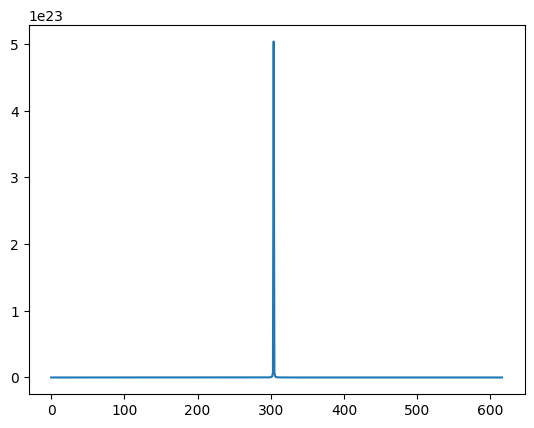

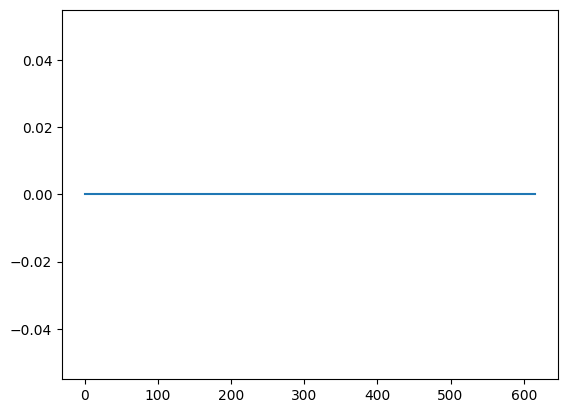

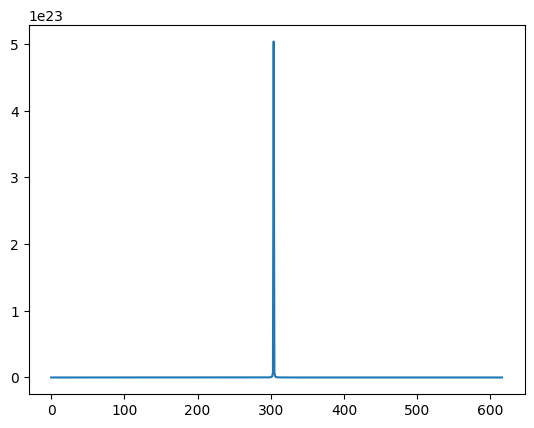

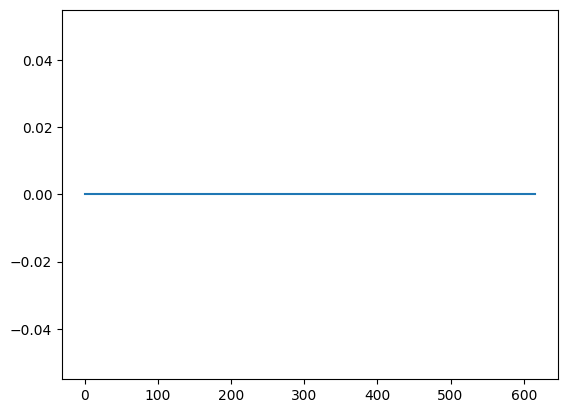

In [188]:
for P in P_list:
    plt.plot(P)
    plt.show()

In [169]:
len(Kmat[Kmat==inf])

312

In [176]:
x = Kmat

In [178]:
x[x==inf] = nan

In [179]:
x.shape

(617, 201)

In [193]:
for j in range(N):
    print(len(E_index_list[n*j:n*(2*N-j)+1]))

601
401
201


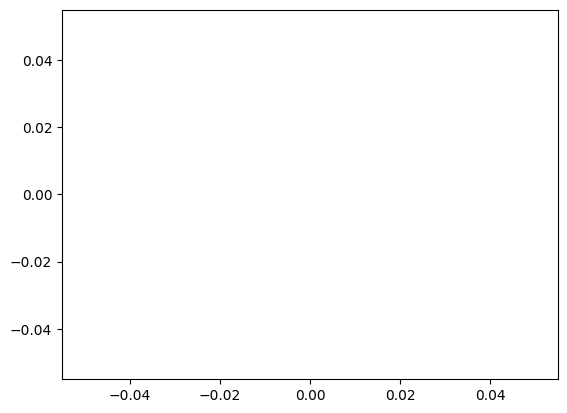

In [182]:
plt.plot(E_pts[imin:imax],Pprev[imin:imax])

In [143]:
Pprev[imin:imax]

array([], dtype=complex128)

In [140]:
imin,imax

(-4, 12)

In [99]:
2*n+1+2*n*(N-1), len(E_pts), len(omega_pts), 2*n+1

(45, 45, 23, 23)

In [89]:
j=0
len(list(range(len(E_pts))[n*j:2*n*N*(1-j)]))

44

In [108]:
x = array([1,2,3,4])
np.flip(x)

array([4, 3, 2, 1])

In [109]:
x

array([1, 2, 3, 4])

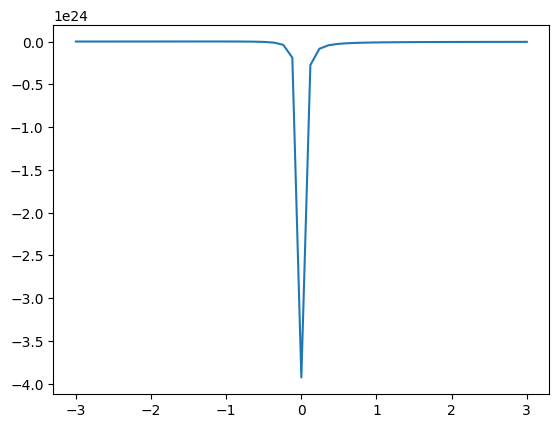

In [68]:
plt.plot(E_pts/(hbar*omega_s),Pnext)

In [72]:
a = np.array([[1,1],[1,1]])
b = np.array([[2,2],[2,2]])
a*b

array([[2, 2],
       [2, 2]])

In [73]:
a = np.mat([[1,1],[1,1]])
b = np.mat([[2,2],[2,2]])
a*b

matrix([[4, 4],
        [4, 4]])

In [75]:
np.matrix([1,1]).shape

(1, 2)

In [85]:
np.array([1,1]).T, np.array([1,1])

(array([1, 1]), array([1, 1]))

In [84]:
np.matrix([1,1]).T,np.matrix([1,1])

(matrix([[1],
         [1]]),
 matrix([[1, 1]]))

In [91]:
one = np.array([1j,0])
np.outer(one.conjugate(),one)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])